In [12]:
import os
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH


import subprocess
import os
import pathlib
import configparser
import sqlite3 as sl
import cv2
from pydub import AudioSegment
import math
import pickle
import shutil
import time
import multiprocessing
from multiprocessing import Process,Queue
import itertools
from threading import Thread
import soundfile as sf
from deepface import DeepFace
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


start_time = time.time()    # To measure execution time in seconds


print("PLEASE EDIT configuration.txt BEFORE EXECUTION")
print(".wav files might be generated in path. The program will automatically delete them. If execuetion stops unexpectedly, please delete them yourself")



datasetPathVideo =  configParser.get('COMMON', 'datasetPathVideo')
datasetPathAudio =  configParser.get('extractAudio', 'datasetPathAudio')
p =  configParser.get('extractAudio', 'dbChunk')
ttwbdf =  int(configParser.get('extractAudio', 'time_to_wait_before_deleting_files'))
cuda =  int(configParser.get('COMMON', 'cuda'))
cpus =  int(configParser.get('COMMON', 'cpus'))
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'



# TODO dataset.db in configuration too

print("Video dataset at " + datasetPathVideo )
print("Number of cpus to use for multiprocessing : ", cpus)


  # Connection to databases
con = sl.connect(datasetPathDatabase,check_same_thread=False)
print('------------------- ABOUT TO START --------------------')

REQUIRED_SAMPLE_RATE = 16000
audio_len = int(configParser.get('train_s2fe_random_forest', 'audio_len'))
BATCH_SIZE = int(configParser.get('train_s2fe_random_forest', 'batch_size'))
EPOCH_SIZE = int(configParser.get('train_s2fe_random_forest', 'epoch_size'))
NO_OF_VIDEOS = int(configParser.get('train_s2fe_random_forest', 'no_of_videos'))
csv_folder =  configParser.get('train_s2fe_random_forest', 'csv_folder')


def read_audio_file(file_path):
  with open(file_path, "rb") as f:
      audio_wave, sample_rate = sf.read(f)
  if sample_rate != REQUIRED_SAMPLE_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {REQUIRED_SAMPLE_RATE}"
      )
  return audio_wave

 
def extractAudio(row):
    absPathVideo = row[0][1]   # for this one video

    absPathAudio = y = absPathVideo.replace(datasetPathVideo,datasetPathAudio)  # for this one audio
    absPathAudio = os.path.splitext(absPathAudio)[0]
    absPathAudio_w = absPathAudio   # without the end
    absPathAudio = absPathAudio + "_audio.wav"  # full path to extracted audio from the video

    #Create Directory
    pathlib.Path(os.path.dirname(absPathAudio)).mkdir(parents=True, exist_ok=True) 

    # Extract audio monochannel and with 16khz and put it in absPathAudio
    command = "ffmpeg -nostats -loglevel 0 -y -i '" + absPathVideo + "' -acodec pcm_s16le -ab 160k -ac 1 -ar 16000 -vn '" + absPathAudio + "'"
    subprocess.call(command, shell=True)


    # Get original duration of video
    audio = AudioSegment.from_file(absPathVideo)
    audio_length_og = math.floor(audio.duration_seconds)
    #print(audio_length_og)
    


    # Will either truncate or loop the original video to reach audio_length (3,6,12 or 24)
    audio_length_list = [audio_len]
    for audio_length in audio_length_list:
        path_var_len_audio =  absPathAudio_w + "audio" + str(audio_length) + "s.wav"    # path to the variable length audio
        path_var_len_audio_temp =  absPathAudio_w + "audio_temp" + str(audio_length) + "s.wav"  # path to a temp version of the variable length audio

        if(audio_length_og > audio_length):
            # Truncate    

            command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + absPathAudio + "\" \"" + path_var_len_audio + "\""
            subprocess.call(command, shell=True)


        else:
            # Loop then truncaate
            #print("lesa")
            twoDigitLenStr = f"{audio_length:02}"
            #print(twoDigitLenStr)
            command = "ffmpeg -nostats -loglevel 0 -y -stream_loop -1 -i '" + absPathAudio + "' -t \"00:00:"+twoDigitLenStr+".000\" -codec:a \"aac\" -f \"wav\" -c copy '"+ path_var_len_audio_temp + "'"
            subprocess.call(command, shell=True)
            command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + path_var_len_audio_temp + "\" \"" + path_var_len_audio + "\""
            subprocess.call(command, shell=True)



            # Will delete those files after a little bit
        ftd = [absPathAudio,path_var_len_audio,os.path.basename(path_var_len_audio),path_var_len_audio_temp]
        audio_wave = read_audio_file(path_var_len_audio)
        
        tDelete = Thread(target=delFiles, args=(ftd,))   # spawn a process
        tDelete.start()
    return audio_wave
        
           




            
# Function to delete audio temp files
def delFiles(filesToDelete):
    time.sleep(ttwbdf)  # wait a bit
    for file in filesToDelete:  
        try:
            os.remove(file)
        except OSError:
            pass
        


from random import randint

def get_video(offset):
    
    try:
        #print('offset:' + str(offset))
        #print('offset:' + str(offset))
        data = con.execute("""SELECT V.ID, V.VIDEO_PATH, F.FACE_PATH FROM VIDEO V 
                        INNER JOIN FACE F ON F.ID = V.ID
                        LIMIT 1 OFFSET """ + str(offset))


        
        #print(data.fetchall())
        dataGotten = data.fetchall()
        if (len(dataGotten)) == 0:
            raise ValueError('No video was fetched')

        #print(dataGotten[0][0])
        audio_wave = extractAudio(dataGotten)
        #audio_wave = audio_wave[0:len_to_input]
        audio_wave = tf.constant(audio_wave, dtype=tf.float64)

        #audio = tf.squeeze(audio_wave, axis=-1)
        fft = tf.signal.fft(
            tf.cast(tf.complex(real=audio_wave, imag=tf.zeros_like(audio_wave)), tf.complex64)
        )
        #fft = tf.expand_dims(fft, axis=-1)
        #fft = tf.squeeze(fft, axis=1)
        #print()
        fft = fft[0:(audio_wave.shape[0] // 2)]
        fft = tf.math.abs(fft)
        #fft = tf.expand_dims(fft, axis=-1)

        embedding_objs = DeepFace.represent(dataGotten[0][2],enforce_detection=False)

            
        embedding_objs = embedding_objs[0]['embedding']
        embedding_objs = np.array(embedding_objs)
        
        #embedding_objs = (embedding_objs - data_mean) / data_std_dev  # Z-score normalization

        return fft,tf.constant(embedding_objs, dtype=tf.float32)
    except Exception as e:
        print('Error getting video, retrying ...:' + str(offset))
        return get_video(randint(1, NO_OF_VIDEOS - 1))


    








PLEASE EDIT configuration.txt BEFORE EXECUTION
.wav files might be generated in path. The program will automatically delete them. If execuetion stops unexpectedly, please delete them yourself
Video dataset at /home/gamal/Datasets/Dataset1/Video
Number of cpus to use for multiprocessing :  8
------------------- ABOUT TO START --------------------


In [13]:
import numpy as np
#np.set_printoptions(threshold=1000000)
v = get_video(1)

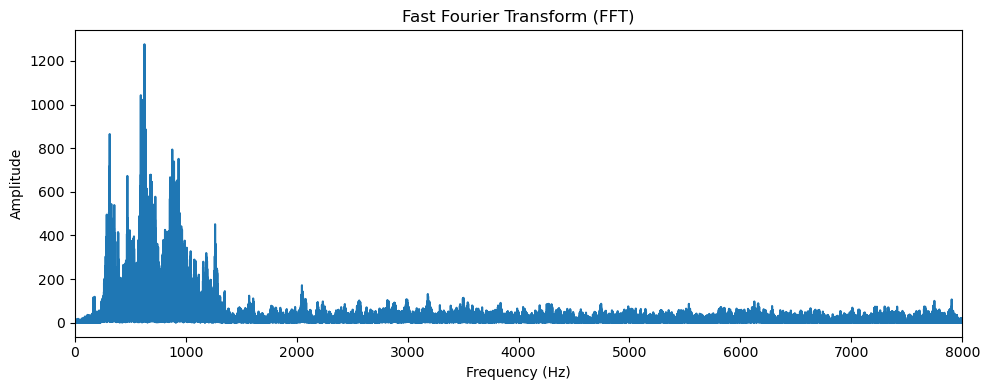

In [14]:
freqs = np.fft.fftfreq(len(v[0].numpy()), 1/REQUIRED_SAMPLE_RATE)  # Frequency axis
import matplotlib.pyplot as plt
# Plot the original signal

t = np.linspace(0, 1, REQUIRED_SAMPLE_RATE, endpoint=False)  # Time array
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)  # Signal

plt.figure(figsize=(10, 4))

plt.subplot(1, 1, 1)
plt.plot(freqs, np.abs(v[0].numpy()))  # Plot only positive frequencies
plt.title('Fast Fourier Transform (FFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, REQUIRED_SAMPLE_RATE//2)  # Limit x-axis to positive frequencies
plt.tight_layout()
plt.show()

In [15]:
import numpy as np

def data_generator(n):
    result_array = np.arange(0, n)
    n =  int(NO_OF_VIDEOS)
    # initialize counter
    value = -1

    
    
    np.random.shuffle(result_array)

    # loop until counter is less than n
    while value < len(result_array) - 1:
        #print(value)
        #print(n)
        value = value + 1
        #print(len(result_array) - 1)
        #print(value)
        yield get_video(result_array[value])

        # increment the counter
        
        



In [21]:
import gc
from IPython.display import clear_output
pre_clone_weights = None

#cloned_models = [tf.keras.models.clone_model(model) for _ in range(2622)]


stacked_data_x = None
stacked_data_y = None
count_g = 0
count_f = 0
for data in data_generator(EPOCH_SIZE):
    count_g = count_g + 1
    data_x = data[0]
    data_y = data[1]
    if stacked_data_x is None:
        stacked_data_x = data_x
        stacked_data_y = data_y
    else:
        try:
            stacked_data_x = tf.stack([stacked_data_x, data_x],axis= 0)
            stacked_data_y = tf.stack([stacked_data_y, data_y], axis= 0)
        except:
            data_x = tf.expand_dims( data[0],axis=0)
            data_y = tf.expand_dims( data[1],axis=0)
            stacked_data_x = tf.concat([stacked_data_x, data_x],axis=0)
            stacked_data_y = tf.concat([stacked_data_y, data_y],axis=0)
        #print(stacked_data_x.shape)
    
    if(not count_g % BATCH_SIZE):
        count_f = count_f + 1
        np.savetxt(csv_folder + "/tree_reg_x" + str(count_f) + "_.csv", stacked_data_x.numpy(), delimiter=",")
        np.savetxt(csv_folder + "/tree_reg_y" + str(count_f) + "_.csv", stacked_data_y.numpy(), delimiter=",")
        stacked_data_x = None
        stacked_data_y = None
        print("Got datapoint no: " + str(count_g))
        print("saved file no: " + str(count_f) + '  ' + csv_folder + "/tree_reg_x" + str(count_f) + "_.csv")
        print("saved file no: " + str(count_f) + '  ' + csv_folder + "/tree_reg_y" + str(count_f) + "_.csv")


Got datapoint no: 10
saved file no: 1  /home/gamal/models//tree_reg_x1_.csv
saved file no: 1  /home/gamal/models//tree_reg_y1_.csv
Got datapoint no: 20
saved file no: 2  /home/gamal/models//tree_reg_x2_.csv
saved file no: 2  /home/gamal/models//tree_reg_y2_.csv
Got datapoint no: 30
saved file no: 3  /home/gamal/models//tree_reg_x3_.csv
saved file no: 3  /home/gamal/models//tree_reg_y3_.csv
Got datapoint no: 40
saved file no: 4  /home/gamal/models//tree_reg_x4_.csv
saved file no: 4  /home/gamal/models//tree_reg_y4_.csv
